This plots evoked raster plots for a given stim event across different states. It can also read in a .csv of different subjects and create a ppt with all plots.

In [34]:
from datetime import date
from glob import glob
import io
import json
import os
from pathlib import Path
import pickle
from PIL import Image
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from scipy import signal, fftpack
from pptx import Presentation
from pptx.util import Inches

In [35]:
sys.path.append(r'C:\Users\lesliec\code')

In [36]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import find_nearest_ind, get_events_wdict

In [37]:
%matplotlib widget

#### Functions

In [38]:
def get_zFR(trig_FR, FRtime):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
    baseline_avg = np.mean(trig_FR[FRtime < 0, :], axis=0)
    baseline_std = np.std(trig_FR[FRtime < 0, :], axis=0)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[:, nonzero_inds] = (trig_FR[:, nonzero_inds] - baseline_avg[None, nonzero_inds]) / baseline_std[None, nonzero_inds]
    
    return trig_Z

In [39]:
def get_good_bad_chs(bad_ch_str, ch_list):
    if bad_ch_str == 'all':
        bad_chs = ch_list
        good_chs = []
    else:
        badchstr = bad_ch_str.replace(' ','')
        bad_chs = []
        for char in badchstr.split(','):
            if char.isdecimal():
                bad_chs.append(int(char))
        good_chs = np.array([x for x in ch_list if x not in bad_chs])
    return good_chs, bad_chs

In [40]:
def save_fig_to_pptx(fig, prs, slide=None, position=None):
    slide_W = 13; slide_H = 7
    set_dpi = 100

    # Save the Matplotlib figure to an in-memory buffer with tight bounding box
    image_buffer = io.BytesIO()
    fig.savefig(image_buffer, format='png', facecolor='white', dpi=set_dpi, bbox_inches='tight')#,pad_inches=0.1)
    image_buffer.seek(0)
    
    # Get figure size
    image = Image.open(image_buffer)
    width, height = image.size
    fig_W_inches = width / set_dpi
    fig_H_inches = height / set_dpi
    
    margin_pad = 0.1
    # Create new slide if none given
    # slide_layouts[5] is a title-only slide
    # slide_layouts[6] is a blank slide
    if slide is None:
        slide = prs.slides.add_slide(prs.slide_layouts[6])

    # Resize the figure if it's larger than the slide dimensions
    if fig_W_inches > slide_W or fig_H_inches > slide_H:
        # Calculate the scaling factor to fit within the slide
        scale_x = slide_W / fig_W_inches
        scale_y = slide_H / fig_H_inches

        # Use the smaller scaling factor to maintain the aspect ratio
        scale = min(scale_x, scale_y)

        # Set the new figure size
        fig.set_size_inches(fig_W_inches * scale, fig_H_inches * scale)
        fig_W_inches = fig.get_figwidth()
        fig_H_inches = fig.get_figheight()

    # Calculate the position and size to center the figure on the slide
    if position is None:
        left = (slide_W - fig_W_inches) / 2  # Center horizontally
        top = (slide_H - fig_H_inches) / 2  # Center vertically
    else:
        left = position[0]; top = position[1]

    # Convert to float point length (?)
    left = left * Inches(1)
    top = top * Inches(1)
    width = fig_W_inches * Inches(1)
    height = fig_H_inches * Inches(1)

    # Add the figure from the in-memory buffer to the slide
    pic = slide.shapes.add_picture(image_buffer, left, top, width, height)
    
    # Close the in-memory buffer
    image_buffer.close()
    image.close()

#### Set paths

In [41]:
data_dir = Path(r"F:\\")
plotsavedir = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\data\plots\echo_analysis\raster_ppts")

In [42]:
plot_states = ['awake', 'isoflurane']

#### Load metadata from excel sheets

In [43]:
_gc = gspread.service_account() # need a key file to access the account
## Load Templeton log ##
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
Temp_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe
## Load Zap&zip log ##
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
ZZ_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

### Load subjects file

In [44]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\psilocybin_saline_subjects_2024_07.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str})

In [45]:
subject_df.head()

,exp_type,mouse,experiment,sweep_states,bad_chs,analyze_EEG,analyze_NPX,CCF_res,notes
0,urethane,582386,urethane_2021-07-15_11-36-58,urethane,"0,2,3",True,True,10,NaN
1,urethane,638703,urethane_estim_2022-10-14_12-25-20,urethane,"0,3,4,6,7,11,13",True,True,25,NaN
2,urethane,654181,urethane_vis_2022-11-23_08-30-16,urethane,"7,8,11,13",True,True,25,NaN
3,saline,654182,estim_vis_2022-12-01_10-33-50,"awake,saline","3,6,14,22,23",True,True,25,NaN
4,urethane,654182,urethane_vis_2022-12-02_11-02-25,urethane,"3,6,14,22,23",True,True,25,NaN


### Choose subject to plot

In [46]:
subrow = subject_df.iloc[37]
print(subrow.mouse)

689239


In [47]:
data_paths = os.path.join(data_dir, '*', 'mouse'+subrow.mouse, subrow.experiment, 'experiment1', 'recording1')
if len(glob(data_paths)) == 0:
    print('This data path does not exist locally: {}.\n'.format(data_paths))

exp = EEGexp(glob(data_paths)[0], preprocess=False, make_stim_csv=False)
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

Experiment type: electrical and sensory stimulation
aw_iso


Load stim table and add state label

In [48]:
stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
stim_log['stimname'] = ['estim_'+y if x == 'biphasic' else 'visual_'+x for x, y in zip(stim_log['stim_type'].values, stim_log['parameter'].values)]
### Get all states in experiment ###
all_sweeps = np.unique(stim_log['sweep'].values)

## Get state label for each sweep ##
sweep_state_list = []
for char in subrow.sweep_states.split(','):
    sweep_state_list.append(char)
if len(sweep_state_list) == 1:
    sweep_state_list = sweep_state_list * len(all_sweeps)
stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
## Get list of states ##
states = np.unique(stim_log['state'].values)
stimevents = np.unique(stim_log['stimname'].values)

print(states)
print(stimevents)

['awake' 'isoflurane']
['estim_30' 'estim_50' 'estim_70' 'visual_circle']


Load EEG traces

Load unit data

In [49]:
## Set FR time bin size ##
time_bin = 0.005 # s

## Set region unit threshold ##
unit_threshold = 5 # must have at least this number of units to be included in analysis

In [50]:
## Load unit info ##
fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'evoked_data', 'units_event_spikes.pkl'), 'rb') as unit_file:
        all_unit_event_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))
#     continue

## Make time bins for event spikes ##
bins = np.arange(all_unit_event_spikes['event_window'][0], all_unit_event_spikes['event_window'][1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region
0,B5,probeB,0,3700,0.645561,VAL,248,176,186,SM-TH
1,B1,probeB,1,3700,0.549414,VAL,248,176,186,SM-TH
2,B666,probeB,1,3700,0.535678,VAL,248,176,186,SM-TH
3,B2,probeB,1,3700,0.618090,VAL,248,176,186,SM-TH
4,B6,probeB,2,3680,0.521943,VAL,248,175,186,SM-TH


In [51]:
np.unique(unit_info['parent_region'].values)

array(['ACA', 'HIP', 'MO', 'OLF', 'PAL', 'PL', 'RHP', 'RT-TH', 'SM-TH',
       'SS', 'STR', 'VIS', 'other-TH'], dtype=object)

In [52]:
ROI_unit_info = {}
reg_ratio = []
for region in np.unique(unit_info['parent_region'].values):
    udf = unit_info[unit_info['parent_region'] == region]
    if len(udf) >= unit_threshold:
        ROI_unit_info[region] = udf.sort_values(by='depth').reset_index(drop=True)
        print('{}: {:d} units'.format(region, len(udf)))
        reg_ratio.append(len(udf))

ACA: 15 units
HIP: 129 units
MO: 80 units
OLF: 7 units
PAL: 16 units
PL: 31 units
RHP: 71 units
RT-TH: 6 units
SM-TH: 177 units
SS: 257 units
STR: 144 units
VIS: 136 units
other-TH: 210 units


### Testing raster plots

#### Make all stim raster plot for a unit

### Loop through all units and find BL firing rates

## Next: try to find units that have enough spikes to care about then make some raster plots with baseline firing rate, and spike counts

Units with baseline firing rate > 0.5 Hz

In [53]:
stimevents

array(['estim_30', 'estim_50', 'estim_70', 'visual_circle'], dtype=object)

In [55]:
early_win = [0.001, 0.025]
late_win = [0.1, 0.25]
blfr_cutoff = 0.5
statei = 'awake'
Estimevs = [x for x in stimevents if 'estim' in x]
print(Estimevs)

['estim_30', 'estim_50', 'estim_70']


In [56]:
## Create a new PowerPoint presentation to save figures to ##
prs = Presentation()
prs.slide_width = Inches(13)
prs.slide_height = Inches(7)

## Add title slide ##
slide = prs.slides.add_slide(prs.slide_layouts[0])
slide.shapes.title.text = r'{} - {}: raster plots'.format(subrow.mouse, subrow.experiment)

In [57]:
for regi, regdf in ROI_unit_info.items():
    print(regi)
    for ii, unitrow in regdf.iterrows():
        print(' {}'.format(unitrow.unit_id))
        allevents_BLFR = (
            np.array([np.sum(spikesi < 0) for spikesi in all_unit_event_spikes['event_spikes'][unitrow.unit_id]]) / 
            (0 - all_unit_event_spikes['event_window'][0])
        )
        if np.mean(allevents_BLFR) < blfr_cutoff:
            continue
        
        figc = plt.figure(figsize=(13, 7))
        figc.suptitle(
            '{}: ch {:d}, {}, wavedur={:.2f}, spontFR={:.2f} Hz ({})'.format(
                unitrow.unit_id, unitrow.peak_ch, unitrow.region, unitrow.spike_duration, np.mean(allevents_BLFR), statei
            ))
        rgs = GridSpec(3, 1, figure=figc, left=0.05, right=0.4, bottom=0.1, top=0.92, hspace=0.1)
        scgs = GridSpec(3, 3, figure=figc, left=0.45, right=0.8, bottom=0.1, top=0.92, hspace=0.1, wspace=0.15)
        compgs = GridSpec(3, 1, figure=figc, left=0.86, right=0.99, bottom=0.1, top=0.92, hspace=0.1)
        
        for ri, stimi in enumerate(Estimevs):
            event_inds = get_events_wdict(stim_log, {'stimname': stimi, 'state': statei, 'good': True}, out='index')
            xs = np.random.normal(ri, 0.08, len(event_inds))
            # Collect trial data #
            blfr = np.zeros((len(event_inds)), dtype=float)
            first_spc = np.zeros((len(event_inds)), dtype=int)
            late_spc = np.zeros((len(event_inds)), dtype=int)
            # Make raster #
            rax = figc.add_subplot(rgs[ri])
            rax.axvspan(early_win[0], early_win[1], color='r', alpha=0.1)
            rax.axvspan(late_win[0], late_win[1], color='r', alpha=0.1)
            for jj, ej in enumerate(event_inds):
                spikesjj = all_unit_event_spikes['event_spikes'][unitrow.unit_id][ej]
                blfr[jj] = np.sum(spikesjj < 0) / (0 - all_unit_event_spikes['event_window'][0])
                first_spc[jj] = len(np.nonzero((spikesjj > early_win[0]) & (spikesjj < early_win[1]))[0])
                late_spc[jj] = len(np.nonzero((spikesjj > late_win[0]) & (spikesjj < late_win[1]))[0])
                rax.eventplot(spikesjj, lineoffsets=jj, linelengths=0.95, color='black')
            rax.set_xlim([-2.0, 2.0])
            rax.set_ylabel('{}'.format(stimi))
        
            # Plot scatters #
            scax1 = figc.add_subplot(scgs[ri, 0])
            scax1.plot(blfr, first_spc, c='k', linestyle='none', marker='o', alpha=0.1)
            scax1.set_ylabel('First spike')
            scax1.set_ylim([-0.2, 3])
            scax2 = figc.add_subplot(scgs[ri, 1])
            scax2.plot(blfr, late_spc, c='k', linestyle='none', marker='o', alpha=0.1)
            scax2.set_ylabel('Rebound spike')
            scax2.set_ylim([-0.3, 6])
            scax3 = figc.add_subplot(scgs[ri, 2])
            scax3.plot(first_spc, late_spc, c='k', linestyle='none', marker='o', alpha=0.1)
            scax3.set_xlim([-0.2, 3])
            scax3.set_ylim([-0.3, 6])
        
            if ri+1 < len(stimevents):
                rax.set_xticklabels([])
                scax1.set_xticklabels([])
                scax2.set_xticklabels([])
                scax3.set_xticklabels([])
            else:
                rax.set_xlabel('Time from stim onset (s)')
                scax1.set_xlabel('BL firing (Hz)')
                scax2.set_xlabel('BL firing (Hz)')
                scax3.set_xlabel('First spike count')
        
            # Plot box plots for each stim #
            if ri == 0:
                coax1 = figc.add_subplot(compgs[0])
                coax1.set_ylabel('BL firing (Hz)')
                coax2 = figc.add_subplot(compgs[1])
                coax2.set_ylabel('First spike count')
                coax2.set_ylim([-0.2, 3])
                coax3 = figc.add_subplot(compgs[2])
                coax3.set_ylabel('Rebound spike count')
                coax3.set_ylim([-0.3, 6])
            coax1.scatter(xs, blfr, c='k', marker='o', alpha=0.1)
            coax1.boxplot(blfr, positions=[ri], showfliers=False)
            coax2.scatter(xs, first_spc, c='k', marker='o', alpha=0.1)
            coax2.boxplot(first_spc, positions=[ri], showfliers=False)
            coax3.scatter(xs, late_spc, c='k', marker='o', alpha=0.1)
            coax3.boxplot(late_spc, positions=[ri], showfliers=False)

        plt.close(figc)
        save_fig_to_pptx(figc, prs)

ACA
 F329
 F330
 F663
 F661
 F660
 F731
 F324
 F319
 F321
 F320
 F311
 F313
 F658
 F297
 F298
HIP
 B460
 B459
 B458
 D155
 D604
 B454
 B450
 C420
 C421
 B449
 B433
 B438
 B432
 B439
 B417
 B755
 C858
 B763
 B764
 B408
 B413
 B709
 B756
 B426
 B777
 B425
 B711
 C402
 B411
 B409
 B412
 B772
 B779
 B405
 B423
 B771
 B406
 B704
 B399
 B392
 B389
 B703
 C392
 B702
 B372
 C388
 B363
 B753
 B701
 B697
 B360
 C387
 B354
 C384
 B770
 B351
 C382
 B347
 B350
 B349
 B341
 B769
 B340
 B336
 C857
 B693
 B335
 B327
 C856
 B690
 B691
 B320
 B313
 C355
 B687
 B689
 B300
 C348
 C956
 C337
 B297
 B295
 B285
 B291
 C854
 C853
 C852
 C334
 C332
 C331
 C328
 C849
 C329
 B283
 C327
 C324
 C850
 C325
 B284
 C321
 C851
 C320
 C318
 C313
 C847
 C323
 C309
 C307
 C308
 C298
 C295
 C843
 C289
 C935
 C844
 C285
 C286
 B281
 C284
 C283
 C281
 C279
 B280
 C266
 C270
 C263
 C248
 C836
 C837
MO
 F559
 F555
 F548
 F700
 F534
 F533
 F531
 F537
 F528
 F525
 F524
 F696
 F521
 F520
 F692
 F695
 F507
 F515
 F498
 F497
 F499

In [58]:
## Save the ppt ##
prs.save(os.path.join(plotsavedir, 'mouse{}_{}_{}_rasters.pptx'.format(subrow.mouse, exp_tag, statei)))

In [46]:
# EEG_traces = {}
unit_spikes = {}
unit_FR = {}
for stimi in stimevents:
    print(stimi)
    # EEG_traces[stimi] = {}
    unit_FR[stimi] = {}
    for statei in plot_states:
        unit_FR[stimi][statei] = {}
        event_inds = get_events_wdict(stim_log, {'stimname': stimi, 'state': statei, 'good': True}, out='index') #'resting_trial': True

        ## Get EEG traces ##
        # event_traces = all_EEG_traces[:, :, event_inds]
        # event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
        # EEG_traces[stimi][statei] = [EEG_event_timestamps, np.mean(event_traces, axis=2)]

        ## Get units z-score ##
        for regi, regdf in ROI_unit_info.items():
            unit_firing_rates = np.zeros((len(timex), len(regdf)), dtype=float) * np.nan
            reg_unit_metrics = []
            for ii, unitrow in regdf.iterrows():
                unit_event_spikes = [all_unit_event_spikes['event_spikes'][unitrow.unit_id][ei] for ei in event_inds]
                unit_event_counts, edges = np.histogram(np.concatenate(unit_event_spikes), bins)
                unit_firing_rates[:, ii] = unit_event_counts / (time_bin * len(event_inds))
            unit_FR[stimi][statei][regi] = [timex, unit_firing_rates]

estim_20
estim_40
estim_70
visual_circle


### Plot traces

In [35]:
stimevents

array(['estim_20', 'estim_40', 'estim_70', 'visual_circle'], dtype=object)

Text(0.5, 0.98, '569069 (estim_vis2): estim_70')

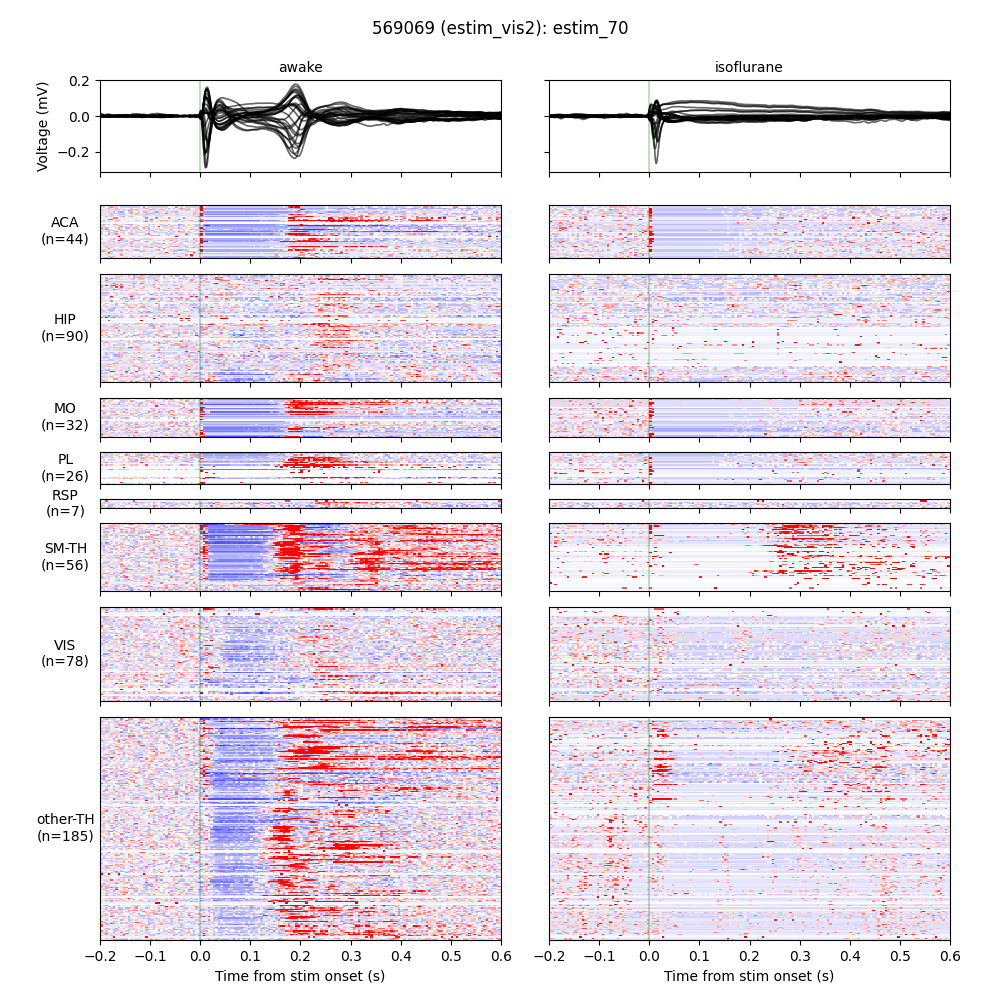

In [61]:
plot_stim = 'estim_70'
Zlim = 5
plwin = [-0.2, 0.6]

fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[1, 8], left=0.1, right=0.95, top=0.92, bottom=0.06, hspace=0.08)
EEGaxs = gs[0].subgridspec(ncols=len(plot_states), nrows=1, wspace=0.12).subplots(sharex=True, sharey=True)
zaxs = gs[1].subgridspec(
    ncols=len(plot_states), nrows=len(reg_ratio), height_ratios=reg_ratio, hspace=0.2, wspace=0.12
).subplots(sharex=True)

for coli, statei in enumerate(plot_states):
    EEGaxs[coli].axvline(0, color='g', alpha=0.25)
    EEGaxs[coli].plot(EEG_traces[plot_stim][statei][0], EEG_traces[plot_stim][statei][1][:, GOOD_CHS] * 1e-3, 'k', linewidth=1.2, alpha=0.6)
    EEGaxs[coli].set_xticklabels([])
    EEGaxs[coli].set_title('{}'.format(statei))
    for ii, (regi, regdf) in enumerate(ROI_unit_info.items()):
        imunit = zaxs[ii,coli].imshow(
                unit_traces[plot_stim][statei][regi][1].T, cmap='bwr', interpolation='none', aspect='auto', origin='upper', vmin=-Zlim, vmax=Zlim,
                extent=[unit_traces[plot_stim][statei][regi][0][0], unit_traces[plot_stim][statei][regi][0][-1], 0, unit_traces[plot_stim][statei][regi][1].shape[1]],
            )
        zaxs[ii,coli].axvline(0, color='g', alpha=0.25)
        zaxs[ii,coli].set_yticks([])
        if coli == 0:
            zaxs[ii,coli].set_ylabel('{}\n(n={:d})'.format(regi, unit_traces[plot_stim][statei][regi][1].shape[1]), rotation=0, va='center', labelpad=25)
    
    zaxs[ii,coli].set_xlim(plwin)
    zaxs[ii,coli].set_xlabel('Time from stim onset (s)')
    
EEGaxs[coli].set_xlim(plwin)
EEGaxs[0].set_ylabel('Voltage (mV)')
fig.suptitle('{} ({}): {}'.format(exp.mouse, exp_tag, plot_stim))

## Save ##
# figname = 'evokedZ_{}_{}_{}_allregions.png'.format(exp.mouse, exp_tag, pltrials)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=False, dpi=300)

# Loop through all subjects

In [13]:
## Set FR time bin size ##
time_bin = 0.005 # s

## Set region unit threshold ##
unit_threshold = 5 # must have at least this number of units to be included in analysis

Zlim = 5
plwin = [-0.2, 0.6]

In [20]:
## Create a new PowerPoint presentation to save figures to ##
prs = Presentation()
prs.slide_width = Inches(13)
prs.slide_height = Inches(7)

## Add title slide ##
slide = prs.slides.add_slide(prs.slide_layouts[0])
slide.shapes.title.text = f'EEG and unit z-score EP plots'
slide.placeholders[1].text = 'Estim and visual EPs\n{}'.format(date.today().strftime('%b %d, %Y'))

for indi, subrow in subject_df.iterrows():
    print('{} - {} exp'.format(subrow.mouse, subrow.exp_type))

    data_paths = os.path.join(data_dir, '*', 'mouse'+subrow.mouse, subrow.experiment, 'experiment1', 'recording1')
    if len(glob(data_paths)) == 0:
        print(' This data path does not exist locally: {}.\n'.format(data_paths))
        continue
    
    exp = EEGexp(glob(data_paths)[0], preprocess=False, make_stim_csv=False)
    exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]

    ### STIM LOG ###
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
    stim_log['stimname'] = ['estim_'+y if x == 'biphasic' else 'visual_'+x for x, y in zip(stim_log['stim_type'].values, stim_log['parameter'].values)]
    ### Get all states in experiment ###
    all_sweeps = np.unique(stim_log['sweep'].values)
    ## Get state label for each sweep ##
    sweep_state_list = []
    for char in subrow.sweep_states.split(','):
        sweep_state_list.append(char)
    if len(sweep_state_list) == 1:
        sweep_state_list = sweep_state_list * len(all_sweeps)
    stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
    ## Get list of states ##
    states = np.unique(stim_log['state'].values)
    stimevents = np.unique(stim_log['stimname'].values)

    ### LOAD EEG ###
    all_EEG_traces = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
    EEG_event_timestamps = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
    eeg_chs = np.arange(0, all_EEG_traces.shape[1])
    GOOD_CHS, bad_chs = get_good_bad_chs(subrow['bad_chs'], eeg_chs)

    ### LOAD UNITS ###
    fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
    if os.path.exists(fn_units_info):
        unit_info = pd.read_csv(fn_units_info)
        with open(os.path.join(exp.data_folder, 'evoked_data', 'units_event_spikes.pkl'), 'rb') as unit_file:
            all_unit_event_spikes = pickle.load(unit_file)
    else:
        print(' {} not found. Not analyzing this subject.\n'.format(fn_units_stats))
        continue
    bins = np.arange(all_unit_event_spikes['event_window'][0], all_unit_event_spikes['event_window'][1] + time_bin, time_bin)
    timex = bins[:-1] + time_bin/2
    ROI_unit_info = {}
    reg_ratio = []
    for region in np.unique(unit_info['parent_region'].values):
        udf = unit_info[unit_info['parent_region'] == region]
        if len(udf) >= unit_threshold:
            ROI_unit_info[region] = udf.sort_values(by='depth').reset_index(drop=True)
            # print('{}: {:d} units'.format(region, len(udf)))
            reg_ratio.append(len(udf))

    ### GET EVENT TRACES ###
    EEG_traces = {}
    unit_traces = {}
    for stimi in stimevents:
        EEG_traces[stimi] = {}
        unit_traces[stimi] = {}
        for statei in plot_states:
            unit_traces[stimi][statei] = {}
            event_inds = get_events_wdict(stim_log, {'stimname': stimi, 'state': statei, 'good': True}, out='index') #'resting_trial': True
    
            ## Get EEG traces ##
            event_traces = all_EEG_traces[:, :, event_inds]
            event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
            EEG_traces[stimi][statei] = [EEG_event_timestamps, np.mean(event_traces, axis=2)]
    
            ## Get units z-score ##
            for regi, regdf in ROI_unit_info.items():
                unit_firing_rates = np.zeros((len(timex), len(regdf)), dtype=float) * np.nan
                reg_unit_metrics = []
                for ii, unitrow in regdf.iterrows():
                    unit_event_spikes = [all_unit_event_spikes['event_spikes'][unitrow.unit_id][ei] for ei in event_inds]
                    unit_event_counts, edges = np.histogram(np.concatenate(unit_event_spikes), bins)
                    unit_firing_rates[:, ii] = unit_event_counts / (time_bin * len(event_inds))
                unit_traces[stimi][statei][regi] = [timex, get_zFR(unit_firing_rates, timex)]

    ### MAKE THE PLOTS ###
    for stimi in stimevents:
        print(' Plotting traces for: {}'.format(stimi))
        fig = plt.figure(figsize=(13, 7))
        gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[1, 8], left=0.1, right=0.95, top=0.92, bottom=0.06, hspace=0.08)
        EEGaxs = gs[0].subgridspec(ncols=len(plot_states), nrows=1, wspace=0.12).subplots(sharex=True, sharey=True)
        zaxs = gs[1].subgridspec(
            ncols=len(plot_states), nrows=len(reg_ratio), height_ratios=reg_ratio, hspace=0.2, wspace=0.12
        ).subplots(sharex=True)
        
        for coli, statei in enumerate(plot_states):
            EEGaxs[coli].axvline(0, color='g', alpha=0.25)
            EEGaxs[coli].plot(EEG_traces[stimi][statei][0], EEG_traces[stimi][statei][1][:, GOOD_CHS] * 1e-3, 'k', linewidth=1.2, alpha=0.6)
            EEGaxs[coli].set_xticklabels([])
            EEGaxs[coli].set_title('{}'.format(statei))
            for ii, (regi, regdf) in enumerate(ROI_unit_info.items()):
                imunit = zaxs[ii,coli].imshow(
                        unit_traces[stimi][statei][regi][1].T, cmap='bwr', interpolation='none', aspect='auto', origin='upper', vmin=-Zlim, vmax=Zlim,
                        extent=[unit_traces[stimi][statei][regi][0][0], unit_traces[stimi][statei][regi][0][-1], 0, unit_traces[stimi][statei][regi][1].shape[1]],
                    )
                zaxs[ii,coli].axvline(0, color='g', alpha=0.25)
                zaxs[ii,coli].set_yticks([])
                if coli == 0:
                    zaxs[ii,coli].set_ylabel('{}\n(n={:d})'.format(regi, unit_traces[stimi][statei][regi][1].shape[1]), rotation=0, va='center', labelpad=25)
            
            zaxs[ii,coli].set_xlim(plwin)
            zaxs[ii,coli].set_xlabel('Time from stim onset (s)')
            
        EEGaxs[coli].set_xlim(plwin)
        EEGaxs[0].set_ylabel('Voltage (mV)')
        fig.suptitle('{} ({}): {}'.format(exp.mouse, exp_tag, stimi))
        plt.close(fig)
        save_fig_to_pptx(fig, prs)
        print('  Added figures to ppt.\n')
    print('')

569068 - isoflurane exp
Experiment type: electrical and sensory stimulation
 Plotting traces for: estim_10
  Added figures to ppt.

 Plotting traces for: estim_20
  Added figures to ppt.

 Plotting traces for: estim_40
  Added figures to ppt.

 Plotting traces for: visual_circle
  Added figures to ppt.


569069 - isoflurane exp
Experiment type: electrical and sensory stimulation
 Plotting traces for: estim_20
  Added figures to ppt.

 Plotting traces for: estim_40
  Added figures to ppt.

 Plotting traces for: estim_70
  Added figures to ppt.

 Plotting traces for: visual_circle
  Added figures to ppt.


569064 - isoflurane exp
Experiment type: electrical and sensory stimulation
 Plotting traces for: estim_15
  Added figures to ppt.

 Plotting traces for: estim_40
  Added figures to ppt.

 Plotting traces for: estim_60
  Added figures to ppt.

 Plotting traces for: visual_circle
  Added figures to ppt.


676726 - isoflurane exp
Experiment type: electrical and sensory stimulation
 Plott

In [21]:
len(prs.slides)

21

In [22]:
## Save the ppt ##
prs.save(os.path.join(plotsavedir, 'EEG_units_EPs_{}.pptx'.format(date.today().strftime('%b%d%Y'))))